In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
#Uncomment the line below to check the names of the files in the dirrectory
#!ls german-traffic-signs

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [0]:
#Change the path of the following commands to set a new directory

#Training set file path:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)

#Validation set file path:  
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)

#Test set file path:  
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
          
#print(type(train_data))
          
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


In [0]:
#This cell has commands to check the image dimensions
#print(X_train.shape)
#print(X_val.shape)
#print(X_test.shape)

In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"

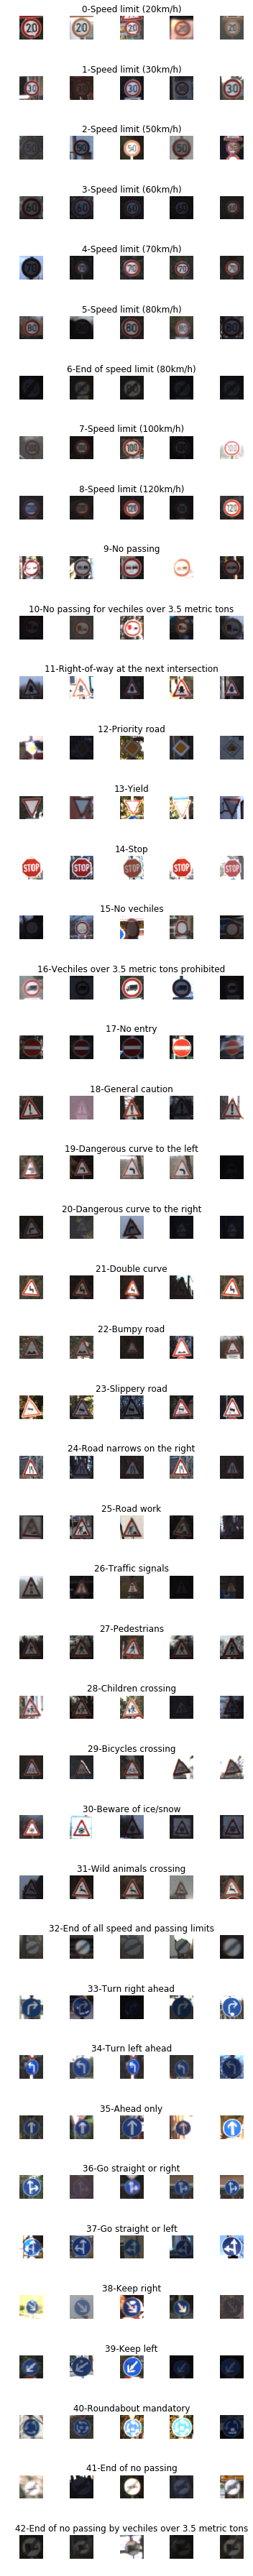

In [0]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


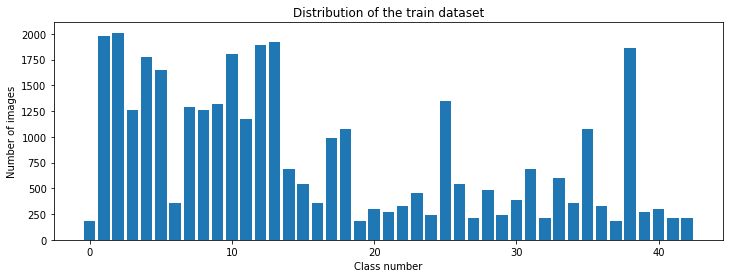

In [0]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel ("Class number")
plt.ylabel ("Number of images")
plt.show()

(32, 32, 3)
36


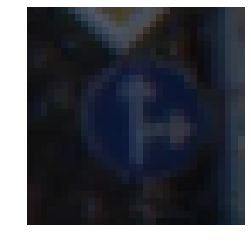

In [0]:
import cv2


plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


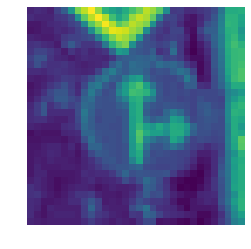

In [0]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img
  
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print (img.shape)

(32, 32)


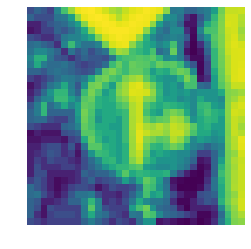

In [0]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


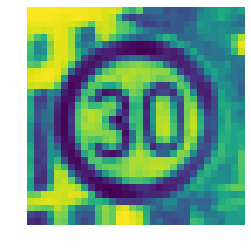

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) -1)])
plt.axis("off")
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
datagen.fit(X_train)

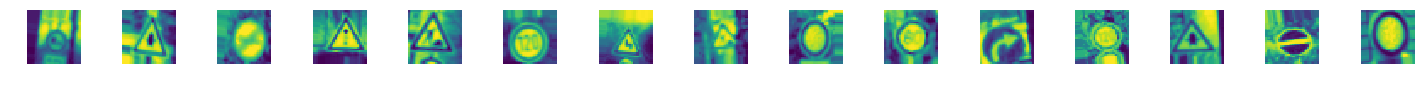

In [0]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [0]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [0]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  #compile model
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model


In [0]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 480)               0         
__________

In [0]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
2000/2000 [==============================] - 37s 18ms/step - loss: 0.8603 - acc: 0.7464 - val_loss: 0.0968 - val_acc: 0.9703
Epoch 2/10
2000/2000 [==============================] - 35s 17ms/step - loss: 0.1952 - acc: 0.9395 - val_loss: 0.0337 - val_acc: 0.9905
Epoch 3/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1324 - acc: 0.9581 - val_loss: 0.0460 - val_acc: 0.9859
Epoch 4/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1021 - acc: 0.9686 - val_loss: 0.0422 - val_acc: 0.9868
Epoch 5/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.0903 - acc: 0.9722 - val_loss: 0.0286 - val_acc: 0.9912
Epoch 6/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.0772 - acc: 0.9772 - val_loss: 0.0259 - val_acc: 0.9916
Epoch 7/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.0686 - acc: 0.9792 - val_loss: 0.0246 - val_acc: 0.9923
Epoch 8/10
2000/2000 [==========================

Text(0.5, 0, 'epoch')

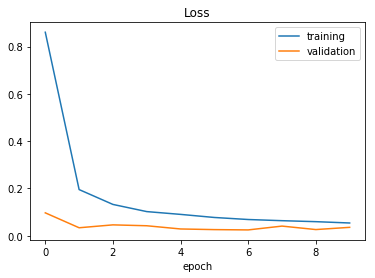

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

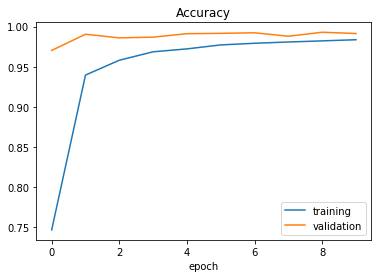

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [0]:
score = model.evaluate(X_test, y_test, verbose = 0)

print('Test Score', score[0])
print('Test Accuracy', score[1])

Test Score 0.14792387325917397
Test Accuracy 0.9692003167534479


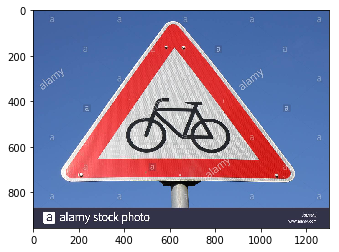

In [0]:
#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


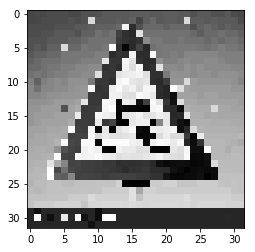

In [0]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)

In [0]:
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [30]
